In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [35]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [36]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

In [37]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [38]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [39]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [40]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [41]:
ds_info.features["label"].num_classes

10

In [42]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

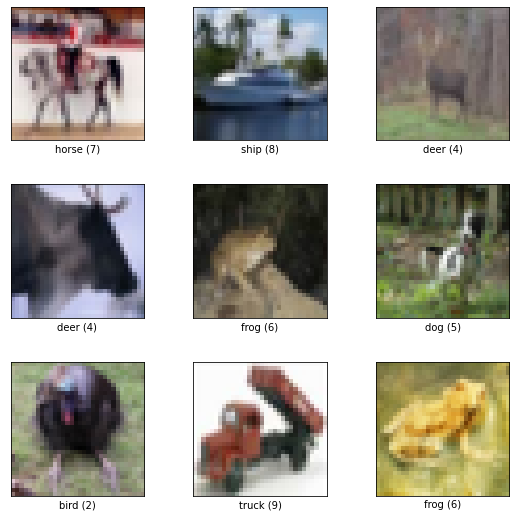

In [43]:
fig = tfds.show_examples(ds_train, ds_info)

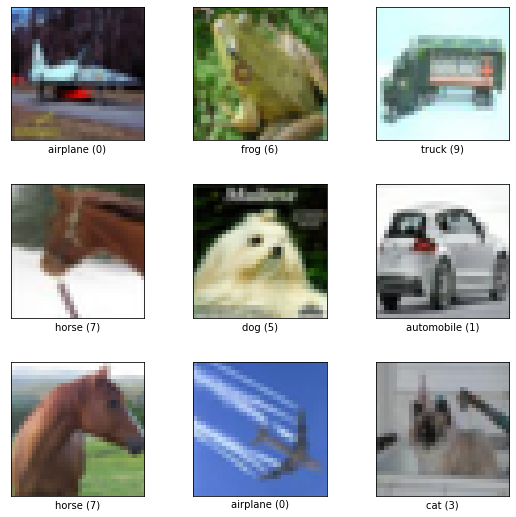

In [44]:
fig = tfds.show_examples(ds_test, ds_info)

ResNet을 바로 구현하는 것은 어려울 수 있으므로, 지금부터 조금 더 간단한 블록이 반복되는 VGG(16,19)를 예시로 구현해 보겠습니다.
블록을 구현하기 위해 모델 구조의 특징을 짚어보겠습니다.

* VGG의 블록은 개략적으로 CNN 레이어 여러 개와 Max pooling 레이어 한 개로 이루어집니다.
* CNN은 모두 커널 크기가 3x3 라는 대표적인 특징을 가지고 있습니다. 
* 블록 내 CNN 레이어의 채널은 하나로 유지되지만 서로 다른 블록 간 CNN 레이어의 채널 수는 다를 수 있습니다.
* 블록에 따라서 CNN 레이어의 개수 또한 달라집니다. 
* 블록의 마지막에는 항상 Max Pooling 레이어가 붙습니다.  

따라서 우리의 블록은 CNN 레이어 여러 개와 Maxpooling 레이어 한 개로 이루어질 것이고, CNN의 레이어 수와 채널을 조절할 수 있어야 합니다.

In [12]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [13]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [14]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


이제 기본적인 블록을 만들 수 있는 함수를 만들었으니 이를 합쳐서 전체 모델을 만들 수 있는 함수를 만들어보겠습니다.

* VGG-16(sixteen weighted layers)

In [15]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

* VGG-19

In [17]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

In [18]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
vgg_13 = build_vgg(
    num_cnn_list=[2,2,3,3],
    channel_list=[64,128,256,512]
)

vgg_13.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

우선 CIFAR-10 데이터셋을 불러옵시다.

In [67]:
########################
BATCH_SIZE = 256
EPOCH = 15
########################

In [126]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [43]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
195/195 [==============================] - 84s 263ms/step - loss: 2.1842 - accuracy: 0.1844 - val_loss: 2.0849 - val_accuracy: 0.2349
Epoch 2/15
195/195 [==============================] - 46s 237ms/step - loss: 2.0121 - accuracy: 0.2708 - val_loss: 1.9348 - val_accuracy: 0.2983
Epoch 3/15
195/195 [==============================] - 47s 242ms/step - loss: 1.8847 - accuracy: 0.3240 - val_loss: 1.8152 - val_accuracy: 0.3548
Epoch 4/15
195/195 [==============================] - 48s 244ms/step - loss: 1.7802 - accuracy: 0.3616 - val_loss: 1.7585 - val_accuracy: 0.3763
Epoch 5/15
195/195 [==============================] - 46s 238ms/step - loss: 1.6914 - accuracy: 0.3900 - val_loss: 1.6789 - val_accuracy: 0.4030
Epoch 6/15
195/195 [==============================] - 45s 234ms/step - loss: 1.6266 - accuracy: 0.4112 - val_loss: 1.5997 - val_accuracy: 0.4276
Epoch 7/15
195/195 [==============================] - 44s 225ms/step - loss: 1.5622 - accuracy: 0.4378 - val_loss: 1.5631 - val_ac

steps_per_epoch : 한 번의 에포크(epoch)에서 훈련에 사용할 배치(batch)의 개수를 지정
validation_steps : validation data가 있을 때, 한 번의 에포크(epoch)가 끝날 때, 테스트에 사용되는 배치(batch)의 개수를 지정

In [44]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 57s 264ms/step - loss: 2.2226 - accuracy: 0.1684 - val_loss: 2.1354 - val_accuracy: 0.2301
Epoch 2/15
195/195 [==============================] - 51s 260ms/step - loss: 2.0603 - accuracy: 0.2514 - val_loss: 1.9920 - val_accuracy: 0.2705
Epoch 3/15
195/195 [==============================] - 51s 262ms/step - loss: 1.9300 - accuracy: 0.3023 - val_loss: 1.8525 - val_accuracy: 0.3227
Epoch 4/15
195/195 [==============================] - 51s 261ms/step - loss: 1.8054 - accuracy: 0.3511 - val_loss: 1.7243 - val_accuracy: 0.3841
Epoch 5/15
195/195 [==============================] - 51s 263ms/step - loss: 1.7048 - accuracy: 0.3848 - val_loss: 1.7256 - val_accuracy: 0.4013
Epoch 6/15
195/195 [==============================] - 51s 263ms/step - loss: 1.6424 - accuracy: 0.4082 - val_loss: 1.6069 - val_accuracy: 0.4229
Epoch 7/15
195/195 [==============================] - 51s 261ms/step - loss: 1.5839 - accuracy: 0.4313 - val_loss: 1.5225 - val_ac

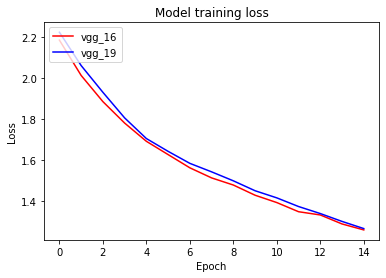

In [45]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
# plt.savefig('example.png', format='png')
plt.show()

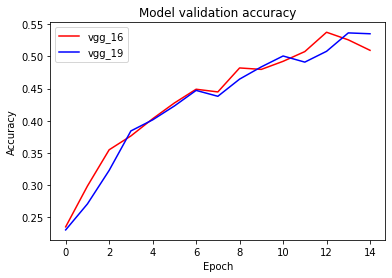

In [46]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
# plt.savefig('example.png', format='png')
plt.show()

In [47]:
# Save history to a file (using pickle)
import pickle

with open('history_16.pkl', 'wb') as f16:
    pickle.dump(history_16.history, f16)
 

In [48]:
# Load history from a file   
with open('history_16.pkl', 'rb') as f16:
    history_16_loaded = pickle.load(f16)

# Now you can use the history object
print(history_16_loaded.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [49]:
# Save history to a file (using pickle)
with open('history_19.pkl', 'wb') as f19:
    pickle.dump(history_19.history, f19)

In [50]:
# Load history from a file       
with open('history_19.pkl', 'rb') as f19:
    history_19_loaded = pickle.load(f19)

# Now you can use the history object
print(history_19_loaded.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Project on resnet

![reference](./reference.png)

* resnet34/50 combi-building(powered by ChatGPT)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=False):
    if conv_shortcut:
        shortcut = Conv2D(filters * 4, 1, strides=stride)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Conv2D(filters, 1, strides=stride)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * 4, 1)(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes, is_50=False):
    input_layer = Input(shape=input_shape)

    x = Conv2D(64, 3, strides=1, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    if is_50:
        x = resnet_block(x, 64, conv_shortcut=True)
        x = resnet_block(x, 64)
        x = resnet_block(x, 64)

        x = resnet_block(x, 128, stride=2, conv_shortcut=True)
        x = resnet_block(x, 128)
        x = resnet_block(x, 128)
        x = resnet_block(x, 128)

        x = resnet_block(x, 256, stride=2, conv_shortcut=True)
        x = resnet_block(x, 256)
        x = resnet_block(x, 256)
        x = resnet_block(x, 256)
        x = resnet_block(x, 256)
        x = resnet_block(x, 256)

        x = resnet_block(x, 512, stride=2, conv_shortcut=True)
        x = resnet_block(x, 512)
        x = resnet_block(x, 512)
    else:
        x = resnet_block(x, 64, conv_shortcut=True)
        x = resnet_block(x, 64)
        x = resnet_block(x, 64)

        x = resnet_block(x, 128, stride=2, conv_shortcut=True)
        x = resnet_block(x, 128)
        x = resnet_block(x, 128)
        x = resnet_block(x, 128)

        x = resnet_block(x, 256, stride=2, conv_shortcut=True)
        x = resnet_block(x, 256)
        x = resnet_block(x, 256)
        x = resnet_block(x, 256)

        x = resnet_block(x, 512, stride=2, conv_shortcut=True)
        x = resnet_block(x, 512)
        x = resnet_block(x, 512)

    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    output_layer = Dense(num_classes, activation='sigmoid')(x)  # 이진분류

    if is_50:
        model = Model(inputs=input_layer, outputs=output_layer, name='resnet50')
    else:
        model = Model(inputs=input_layer, outputs=output_layer, name='resnet34')

    return model

input_shape = (224, 224, 3)
num_classes = 1

In [134]:
# Create ResNet model
model_resnet34 = build_resnet(input_shape, num_classes, is_50=False)
model_resnet34.summary()

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1066 (Conv2D)            (None, 224, 224, 64) 1792        input_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1066 (Batch (None, 224, 224, 64) 256         conv2d_1066[0][0]                
__________________________________________________________________________________________________
activation_1119 (Activation)    (None, 224, 224, 64) 0           batch_normalization_1066[0][0]   
___________________________________________________________________________________________

In [135]:
# Create ResNet model
model_resnet50 = build_resnet(input_shape, num_classes, is_50=True)
model_resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1113 (Conv2D)            (None, 224, 224, 64) 1792        input_30[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1113 (Batch (None, 224, 224, 64) 256         conv2d_1113[0][0]                
__________________________________________________________________________________________________
activation_1162 (Activation)    (None, 224, 224, 64) 0           batch_normalization_1113[0][0]   
___________________________________________________________________________________________

* plainnet34/50 combi-building(powered by ChatGPT)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Dense, Flatten, Add
from tensorflow.keras.models import Model

def plain_block(input_tensor, filters, kernel_size=(3, 3), strides=(1, 1), activation='relu'):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def build_plainnet(input_shape, num_classes, is_50=True):
    input_layer = Input(shape=input_shape, name='input_layer')
    x = input_layer
    
    # Initial convolution
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # PlainNet-50 architecture
    if is_50:
        num_blocks_list = [3, 4, 6, 3]  # PlainNet-50
    else:
        num_blocks_list = [3, 4, 6, 3]  # PlainNet-34

    filters_list = [64, 128, 256, 512]

    # Building stages (blocks of plain blocks)
    for stage_idx, num_blocks in enumerate(num_blocks_list):
        for block_idx in range(num_blocks):
            # Adjusting strides for the first block of each stage except the first stage
            strides = (2, 2) if block_idx == 0 and stage_idx != 0 else (1, 1)
            x = plain_block(x, filters_list[stage_idx], strides=strides)

    # Average pooling and classifier
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='sigmoid', name='fc' + str(num_classes))(x)

    # Create model
    model = Model(inputs=input_layer, outputs=x, name='PlainNet-' + ('50' if is_50 else '34'))
    return model

input_shape = (224, 224, 3)
num_classes = 1

In [80]:
model_plainnet34 = build_plainnet(input_shape, num_classes, is_50=False)
model_plainnet34.summary()

Model: "PlainNet-34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1032 (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_1032 (Ba (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1085 (Activation) (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1033 (Conv2D)         (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_1033 (Ba (None, 56, 56, 64)        

In [81]:
model_plainnet50 = build_plainnet(input_shape, num_classes, is_50=True)
model_plainnet50.summary()

Model: "PlainNet-50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_1049 (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_1049 (Ba (None, 112, 112, 64)      256       
_________________________________________________________________
activation_1102 (Activation) (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1050 (Conv2D)         (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_1050 (Ba (None, 56, 56, 64)        

* cats_vs_dogs 데이터 사용하기

In [101]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [102]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [103]:
setattr(tfds.image_classification.cats_vs_dogs, 
        '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)

In [104]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [105]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [106]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [107]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [108]:
ds_info.features["label"].num_classes

2

In [109]:
ds_info.features["label"].names

['cat', 'dog']

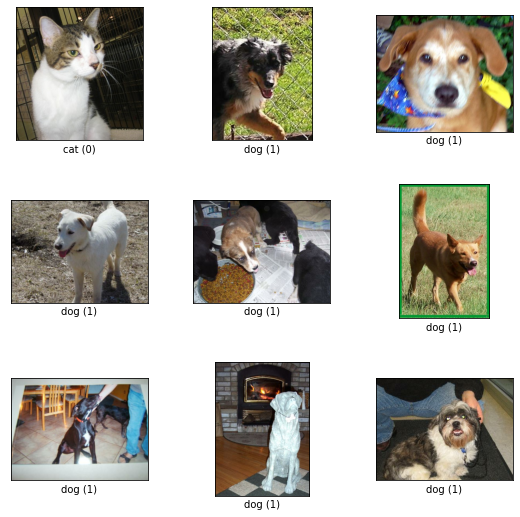

In [110]:
fig = tfds.show_examples(ds_train, ds_info)

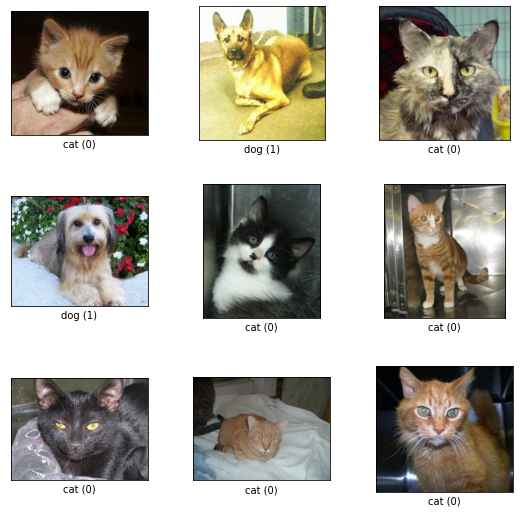

In [111]:
fig = tfds.show_examples(ds_test, ds_info)

In [128]:
########################
BATCH_SIZE = 32
EPOCH = 15
########################

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [129]:
model_resnet34.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model_resnet50.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [139]:
history_resnet34 = model_resnet34.fit(
    ds_train,
    steps_per_epoch=ds_info.splits['train[:80%]'].num_examples//BATCH_SIZE,
    validation_steps=ds_info.splits['train[80%:]'].num_examples//BATCH_SIZE,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer resnet34: expected shape=(None, 224, 224, 3), found shape=(None, None, None, 224, 224, 3)


In [125]:
history_resnet50 = model_resnet50.fit(
    ds_train,
    steps_per_epoch=ds_info.splits['train[:80%]'].num_examples//BATCH_SIZE,
    validation_steps=ds_info.splits['train[80%:]'].num_examples//BATCH_SIZE,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call `repeat()` on the dataset).

In [122]:
model_plainnet34.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

model_plainnet50.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [123]:
history_plainnet34 = model_plainnet34.fit(
    ds_train,
    steps_per_epoch=ds_info.splits['train[:80%]'].num_examples//BATCH_SIZE,
    validation_steps=ds_info.splits['train[80%:]'].num_examples//BATCH_SIZE,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer batch_normalization_1032 is incompatible with the layer: expected ndim=4, found ndim=6. Full shape received: (None, None, None, None, None, 64)


In [124]:
history_plainnet50 = model_plainnet50.fit(
    ds_train,
    steps_per_epoch=ds_info.splits['train[:80%]'].num_examples//BATCH_SIZE,
    validation_steps=ds_info.splits['train[80%:]'].num_examples//BATCH_SIZE,
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer batch_normalization_1049 is incompatible with the layer: expected ndim=4, found ndim=6. Full shape received: (None, None, None, None, None, 64)


# 회고
* 노드에서 변형하는 것이 쉽지 않다. 시간이 부족했다.
* 혼자 해결해야 부분에 대해 두려움을 줄 일 부가적인 노력이 필요하다.
* CV와 NLP의 차이를 다시 CV쪽 공부를 하면서 느끼게 된다.
* 오류와 싸움에서 패배하였다.

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend

def conv_block(x, filters, kernel_size, strides=(1, 1), activation='relu', name=None):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', name=name)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def identity_block(x, filters, name=None):
    f1, f2, f3 = filters
    shortcut = x
    x = conv_block(x, f1, (1, 1), strides=(1, 1), name=name+'_conv1')
    x = conv_block(x, f2, (3, 3), strides=(1, 1), name=name+'_conv2')
    x = conv_block(x, f3, (1, 1), strides=(1, 1), activation=None, name=name+'_conv3')
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def conv_block_with_shortcut(x, filters, strides=(2, 2), name=None):
    f1, f2, f3 = filters
    shortcut = conv_block(x, f3, (1, 1), strides=strides, activation=None, name=name+'_shortcut')
    x = conv_block(x, f1, (1, 1), strides=strides, name=name+'_conv1')
    x = conv_block(x, f2, (3, 3), strides=(1, 1), name=name+'_conv2')
    x = conv_block(x, f3, (1, 1), strides=(1, 1), activation=None, name=name+'_conv3')
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), classes=1000):
    img_input = layers.Input(shape=input_shape)

    x = conv_block(img_input, 64, (7, 7), strides=(2, 2), name='conv1')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)

    x = conv_block_with_shortcut(x, [64, 64, 256], strides=(1, 1), name='conv2_1')
    x = identity_block(x, [64, 64, 256], name='conv2_2')
    x = identity_block(x, [64, 64, 256], name='conv2_3')

    x = conv_block_with_shortcut(x, [128, 128, 512], name='conv3_1')
    x = identity_block(x, [128, 128, 512], name='conv3_2')
    x = identity_block(x, [128, 128, 512], name='conv3_3')
    x = identity_block(x, [128, 128, 512], name='conv3_4')

    x = conv_block_with_shortcut(x, [256, 256, 1024], name='conv4_1')
    x = identity_block(x, [256, 256, 1024], name='conv4_2')
    x = identity_block(x, [256, 256, 1024], name='conv4_3')
    x = identity_block(x, [256, 256, 1024], name='conv4_4')
    x = identity_block(x, [256, 256, 1024], name='conv4_5')
    x = identity_block(x, [256, 256, 1024], name='conv4_6')

    x = conv_block_with_shortcut(x, [512, 512, 2048], name='conv5_1')
    x = identity_block(x, [512, 512, 2048], name='conv5_2')
    x = identity_block(x, [512, 512, 2048], name='conv5_3')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='fc1000')(x)

    model = models.Model(img_input, x, name='resnet50')

    return model

# 모델 인스턴스 생성
model = ResNet50(input_shape=(224, 224, 3), classes=1000)
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_156[0][0]    
___________________________________________________________________________________________

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend

def conv_block(x, filters, kernel_size, strides=(1, 1), activation='relu', name=None):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', name=name)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def identity_block(x, filters, kernel_size, name=None):
    shortcut = x
    x = conv_block(x, filters, kernel_size, strides=(1, 1), activation='relu', name=name+'_conv1')
    x = conv_block(x, filters, kernel_size, strides=(1, 1), activation=None, name=name+'_conv2')
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def conv_block_with_shortcut(x, filters, kernel_size, strides=(2, 2), name=None):
    shortcut = conv_block(x, filters, (1, 1), strides=strides, activation=None, name=name+'_shortcut')
    x = conv_block(x, filters, kernel_size, strides=strides, activation='relu', name=name+'_conv1')
    x = conv_block(x, filters, kernel_size, strides=(1, 1), activation=None, name=name+'_conv2')
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def ResNet34(input_shape=(224, 224, 3), classes=1000):
    img_input = layers.Input(shape=input_shape)

    x = conv_block(img_input, 64, (7, 7), strides=(2, 2), name='conv1')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)

    x = conv_block_with_shortcut(x, 64, (3, 3), strides=(1, 1), name='conv2_1')
    x = identity_block(x, 64, (3, 3), name='conv2_2')
    x = identity_block(x, 64, (3, 3), name='conv2_3')

    x = conv_block_with_shortcut(x, 128, (3, 3), name='conv3_1')
    x = identity_block(x, 128, (3, 3), name='conv3_2')
    x = identity_block(x, 128, (3, 3), name='conv3_3')
    x = identity_block(x, 128, (3, 3), name='conv3_4')

    x = conv_block_with_shortcut(x, 256, (3, 3), name='conv4_1')
    x = identity_block(x, 256, (3, 3), name='conv4_2')
    x = identity_block(x, 256, (3, 3), name='conv4_3')
    x = identity_block(x, 256, (3, 3), name='conv4_4')
    x = identity_block(x, 256, (3, 3), name='conv4_5')
    x = identity_block(x, 256, (3, 3), name='conv4_6')

    x = conv_block_with_shortcut(x, 512, (3, 3), name='conv5_1')
    x = identity_block(x, 512, (3, 3), name='conv5_2')
    x = identity_block(x, 512, (3, 3), name='conv5_3')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='fc1000')(x)

    model = models.Model(img_input, x, name='resnet34')

    return model

# 모델 인스턴스 생성
model = ResNet34(input_shape=(224, 224, 3), classes=1000)
model.summary()

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization_119[0][0]    
___________________________________________________________________________________________

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(x, filters, kernel_size, strides=(1, 1), activation='relu', name=None):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', name=name)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def identity_block(x, filters, is_50, name=None):
    if is_50:
        f1, f2, f3 = filters
        shortcut = x
        x = conv_block(x, f1, (1, 1), strides=(1, 1), name=name+'_conv1')
        x = conv_block(x, f2, (3, 3), strides=(1, 1), name=name+'_conv2')
        x = conv_block(x, f3, (1, 1), strides=(1, 1), activation=None, name=name+'_conv3')
    else:
        f = filters
        shortcut = x
        x = conv_block(x, f, (3, 3), strides=(1, 1), name=name+'_conv1')
        x = conv_block(x, f, (3, 3), strides=(1, 1), activation=None, name=name+'_conv2')
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def conv_block_with_shortcut(x, filters, strides=(2, 2), is_50=True, name=None):
    if is_50:
        f1, f2, f3 = filters
        shortcut = conv_block(x, f3, (1, 1), strides=strides, activation=None, name=name+'_shortcut')
        x = conv_block(x, f1, (1, 1), strides=strides, name=name+'_conv1')
        x = conv_block(x, f2, (3, 3), strides=(1, 1), name=name+'_conv2')
        x = conv_block(x, f3, (1, 1), strides=(1, 1), activation=None, name=name+'_conv3')
    else:
        f = filters
        shortcut = conv_block(x, f, (1, 1), strides=strides, activation=None, name=name+'_shortcut')
        x = conv_block(x, f, (3, 3), strides=strides, name=name+'_conv1')
        x = conv_block(x, f, (3, 3), strides=(1, 1), activation=None, name=name+'_conv2')
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes, is_50=True):
    img_input = layers.Input(shape=input_shape)

    x = conv_block(img_input, 64, (7, 7), strides=(2, 2), name='conv1')
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)

    if is_50:
        block_sizes = [3, 4, 6, 3]
        filters = [64, 128, 256, 512]
        filter_blocks = [[64, 64, 256], [128, 128, 512], [256, 256, 1024], [512, 512, 2048]]
    else:
        block_sizes = [3, 4, 6, 3]
        filters = [64, 128, 256, 512]

    for i, num_blocks in enumerate(block_sizes):
        for j in range(num_blocks):
            if j == 0:
                if is_50:
                    x = conv_block_with_shortcut(x, filter_blocks[i], strides=(2, 2) if i != 0 else (1, 1), is_50=is_50, name=f'conv{i+2}_{j+1}')
                else:
                    x = conv_block_with_shortcut(x, filters[i], strides=(2, 2) if i != 0 else (1, 1), is_50=is_50, name=f'conv{i+2}_{j+1}')
            else:
                if is_50:
                    x = identity_block(x, filter_blocks[i], is_50=is_50, name=f'conv{i+2}_{j+1}')
                else:
                    x = identity_block(x, filters[i], is_50=is_50, name=f'conv{i+2}_{j+1}')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    model = models.Model(img_input, x, name='resnet')

    return model

# 모델 인스턴스 생성
resnet34_model = build_resnet(input_shape=(224, 224, 3), num_classes=1000, is_50=False)
resnet34_model.summary()

# resnet50_model = build_resnet(input_shape=(224, 224, 3), num_classes=1000, is_50=True)
# resnet50_model.summary()


Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_209 (BatchN (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 112, 112, 64) 0           batch_normalization_209[0][0]    
_____________________________________________________________________________________________